In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy
import matplotlib.pyplot as plt
import numpy as np

from pytorch_lightning.loggers import WandbLogger

seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
NUM_WORKERS = int(os.cpu_count() / 2)

Global seed set to 7


In [13]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [2]:
# logger=None
logger=WandbLogger(project="full_attention", name=None)

In [3]:
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
    drop_last=True
)


/home/shats/miniconda3/envs/moti/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:73: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/shats/miniconda3/envs/moti/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:77: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/shats/miniconda3/envs/moti/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:81: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


In [4]:
def create_model():
    model = torchvision.models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model


class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        
        self.fe = torch.nn.Sequential(*(list(create_model().children())[:-1]))
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2),
            # torch.nn.BatchNorm1d(num_channels*2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=2),
            # torch.nn.BatchNorm1d(num_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=2),
            # torch.nn.BatchNorm1d(num_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3),
        )
        self.fc = nn.Sequential(nn.Linear(1060, 10))
        C = 512 # feature dim
        K = 1280 # number of keys in dict
        # self.queue = torch.randn((C, K))# .to(device)
        self.queue = torch.zeros((C, K))# .to(device)

    def forward(self, x):
        out = self.fe(x)
        out = torch.flatten(out, 1) # 256x512 (batchxfeats; feats=C)
        # out_w_queue = self.cat_queue_to_out(out)
        self.update_queue(out.detach())
        out = self.cat_queue_to_out(out).unsqueeze(1).cuda() # unsqueeze for C dim
        out = self.cnn(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        self.log("train_loss", loss)
        self.log("train_acc", acc)
        
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}
    
    ### 🧪 full attention stuff ###
    def cat_queue_to_out(self, out):
        queue_block = self.queue.clone().unsqueeze(0).repeat(256, 1, 1) # make queue torch.Size([256, 512, 1280])
        out_w_queue = torch.cat((out.cpu().unsqueeze(-1), queue_block), -1) # 256x512x1281
        return out_w_queue
    
    def update_queue(self, k):
        # queue is CxK
        # need to roll by batch size, then replace with curr batch
        
        # k.t() is CxN
        batch_size = k.shape[0] # N
        
        self.queue = self.queue.roll(batch_size, 1)
        self.queue[:, :batch_size] = k.t()
        
        # plt.imshow(self.queue, cmap='hot', interpolation='nearest')
        # plt.show()

        

In [14]:
### FROM lucidrains github ###

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)


In [5]:
model = LitResnet(lr=0.05)
model.datamodule = cifar10_dm

In [6]:
model.queue.shape

torch.Size([512, 1280])

In [7]:
trainer = Trainer(
    logger=logger,
    max_epochs=30,
    gpus=AVAIL_GPUS,
    callbacks=[LearningRateMonitor(logging_interval="step")],
)

trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule=cifar10_dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified
Files already downloaded and verified


/home/shats/miniconda3/envs/moti/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:114: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/shats/miniconda3/envs/moti/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:133: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: shatz (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name | Type       | Params
------------------------------------
0 | fe   | Sequential | 11.2 M
1 | cnn  | Sequential | 1.6 K 
2 | fc   | Sequential | 10.6 K
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.724    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 7


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/shats/miniconda3/envs/moti/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
/home/shats/miniconda3/envs/moti/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:152: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.09985977411270142, 'test_loss': 2.3029186725616455}
--------------------------------------------------------------------------------


Traceback (most recent call last):
  File "/home/shats/miniconda3/envs/moti/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/shats/miniconda3/envs/moti/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/shats/miniconda3/envs/moti/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/home/shats/miniconda3/envs/moti/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/shats/miniconda3/envs/moti/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/shats/miniconda3/envs/moti/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/shats/miniconda3/envs/moti/lib/python3

[{'test_loss': 2.3029186725616455, 'test_acc': 0.09985977411270142}]

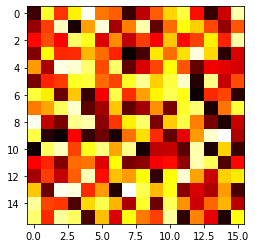

In [8]:
a = np.random.random((16, 16))
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()